#  Plots and tables from CellphoneDB

In [3]:
library(dplyr)
library(reshape2)
library(plyr)
library(RColorBrewer)
library(ggplot2)
library(pheatmap)
library(cowplot)

get_cells2genes = function(CPresults, genes2filter = NULL){
    if( ! is.null(genes2filter) ){
        CPresults = CPresults[ sapply(rownames(CPresults), function(x) any(unlist(Int2Gene[[x]]) %in%  genes2filter) ), ]
        CPresults = CPresults[ , apply(CPresults, 2, sum) > 0]
    }
    # reformat as dataframe                                    
    df = melt(as.matrix(CPresults))
    df = subset(df, value == 1)
    # extract interaction partners
    xA = apply(df, 1, function(x){
        data.frame(cell = strsplit(x[2], '--')[[1]][1],
            gene = Int2Gene[[x[1]]]$partner_a,
                   interaction = x[1], 
                   partner = strsplit(x[2], '--')[[1]][2],
                   row.names = NULL)
    })
    xB = apply(df, 1, function(x){
        data.frame(cell = strsplit(x[2], '--')[[1]][2],
            gene = Int2Gene[[x[1]]]$partner_b,
                   interaction = x[1], 
                   partner = strsplit(x[2], '--')[[1]][1],
                   row.names = NULL)
    })
    x = append(xA, xB)
    # Merge as data frame for plotting with ggplot
    cells2genesCP = melt(x, id.vars = names(x[[1]]))
    cells2genesCP = unique(cells2genesCP[,-5])
    # transfer expression info                                  
    cells2genesCP$id = paste(cells2genesCP$cell, cells2genesCP$gene)
    cells2genesCP$AveExpr_cluster =  AVG$mean[ match(cells2genesCP$id, AVG$id) ]
    cells2genesCP$percentExpr_cluster =  PERC$percent[ match(cells2genesCP$id, PERC$id) ]

    return(cells2genesCP)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize




# Load Cellphone Genes

In [4]:
# Define variables
filter_int_user_curated = T #Use only user_curated interactions?
per_cutoff = 0.1 # min % of cells in the cluster required  with expression > 0 for the gene
pval_cutoff = 0.005 # max adjusted p-value requeired to consider a gene as DEG
logFC_cutoff = 0.2 # min logFC to consider a gene as DEG

In [5]:
# Load cellphone database - genes and complexes file
# Gene names
genes_cpDB = read.delim('~/cellphoneDB/hsa_uniprot.txt', stringsAsFactors = F, sep = '\t')

# Complexes members
com_cpDB = read.csv('/home/jovyan/farm/endometrium/data/cellphoneDB/database/complex_generated.csv', stringsAsFactors = F)
com_cpDB = unique(com_cpDB)
com_cpDB$complex_name = paste0('complex:', com_cpDB$complex_name)
# Generate complexes2gene symbol dictionary
Com2Gene = lapply(com_cpDB$complex_name, function(cx) subset(genes_cpDB, uniprot %in% unlist(com_cpDB[com_cpDB$complex_name == cx, 2:5]) )$gene_name )
Com2Gene = lapply(Com2Gene, unique)
names(Com2Gene) = com_cpDB$complex_name
                  
# Load interactions from invivo/out/means.txt output file                   
int_cpDB = read.delim('/home/jovyan/farm/endometrium_v2/invivo/cellphoneDB/out/means.txt', stringsAsFactors = F)[, 1:10]
# MANDATORY: remove "curated" because we have cleaned and renamed them (this is a long story, just do it)
int_cpDB = subset(int_cpDB, annotation_strategy != 'curated')
# OPTIONAL: Use only user_curated interactions?
if(filter_int_user_curated)
    int_cpDB = subset(int_cpDB, annotation_strategy == 'user_curated')
# Generate Int2Gene dictionary
Int2Gene = apply(int_cpDB, 1, function(int) {
    int = unname(int)
    if(int[5] == '') # if partnerA is complex, then retrieve members from dictionary
       partnerA = Com2Gene[[int[3]]]
    else  # if partnerA is a single gene, take name from file
       partnerA = int[5]
    if(int[6] == '')  # if partnerB is complex, then retrieve members from dictionary
       partnerB = Com2Gene[[int[4]]]
    else  # if partnerB is a single gene, take name from file
       partnerB = int[6]
    list(partner_a=partnerA,partner_b=partnerB)
    }) 
names(Int2Gene) = int_cpDB$interacting_pair

## Load cellphone results file

In [6]:
CPresults = read.csv('invivo/cellphoneDB/out/DEapproach_results_pval0.005_logFC0.2.csv', stringsAsFactors = F)
rownames(CPresults) = CPresults$X
CPresults = CPresults[, -1]
colnames(CPresults) = gsub('\\...', '--', colnames(CPresults))
colnames(CPresults) = gsub('\\.', '_', colnames(CPresults))
# colnames(CPresults) = gsub('Lumenal ', 'Lumenal', colnames(CPresults))
head(CPresults)

,SOX9_LGR5--SOX9_LGR5,Preciliated--Preciliated,Ciliated--Ciliated,SOX9_LGR5--Preciliated,SOX9_LGR5--Ciliated,Preciliated--Ciliated,Preciliated--SOX9_LGR5,Ciliated--SOX9_LGR5,Ciliated--Preciliated,Lumenal_1--Lumenal_1,⋯,PV_STEAP4--Glandular_secretory,Endothelial_ACKR1--Glandular_secretory,Endothelial_SEMA3G--Glandular_secretory,PV_STEAP4--Fibroblast_dS,Endothelial_ACKR1--Fibroblast_dS,Endothelial_SEMA3G--Fibroblast_dS,SOX9--SOX9,Fibroblast_C7--Fibroblast_C7,SOX9--Fibroblast_C7,Fibroblast_C7--SOX9
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
IGF2_IGF1R,0,0,1,0,0,1,1,1,0,0,⋯,1,0,1,0,0,0,0,0,0,1
IGF1_IGF1R,1,0,1,0,1,1,1,1,0,0,⋯,1,0,0,0,0,0,1,0,0,1
IGF2_IGF2R,0,0,0,0,0,0,1,1,0,0,⋯,0,0,0,1,0,1,0,1,0,1
CCL2_ACKR1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CXCL1_ACKR1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CXCL8_ACKR1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0


# Load expression information

In [7]:
# # Load percentage expression info
# # you need to put in a folder a file for each cluster that you included in cellphone
# # The file must contain at least three columns (aka, you can reuse the output of the DEG files):
# # - Gene: gene symbol
# # - cluster: cell type
# # - percentExpr_cluster: % of cells in the cluster with expression > 0 for the gene
# path_DE = '/lustre/scratch117/cellgen/team292/lh20/Sharing/Luz/epithelial_DEtables.rds'
# DE_df = readRDS(path_DE)

# # # Remove genes not in cellphone
# DE_df = lapply(DE_df, function(x) subset(x, rownames(x) %in% genes_cpDB$gene_name )) 

# # # Build dictionary clusters2DEGs
# DE_df = lapply(DE_df, function(x) {
#     x$Log2FC = round(x$Log2FC, digits = 2)
#     x$Gene = rownames(x)
#     return(x)
# } )

In [8]:
# Load percentage expression info
# you need to put in a folder a file for each cluster that you included in cellphone
# The file must contain at least three columns (aka, you can reuse the output of the DEG files):
# - Gene: gene symbol
# - cluster: cell type
# - percentExpr_cluster: % of cells in the cluster with expression > 0 for the gene
path_Exp = '/lustre/scratch117/cellgen/team292/lh20/Sharing/Luz/PercentExpressed.csv'

# Load
Per_df = read.csv(path_Exp, stringsAsFactors = F, row.names = 2) 
Per_df = Per_df[, grep('PcentExpressed_broad_', colnames(Per_df), invert = T) ]
Per_df = Per_df[, grep('PcentExpressed_', colnames(Per_df)) ]
colnames(Per_df) = gsub('PcentExpressed_', '', colnames(Per_df))
colnames(Per_df) = gsub('\\.', '_', colnames(Per_df))
colnames(Per_df) = gsub('^ciliated', 'Ciliated', colnames(Per_df))
colnames(Per_df) = gsub('pre.ciliated', 'Preciliated', colnames(Per_df))
colnames(Per_df) = gsub('Endothelial_Lymphoid', 'Lymphoid', colnames(Per_df))
colnames(Per_df) = gsub('Endothelial_Myeloid', 'Myeloid', colnames(Per_df))


# Filetr expressed
Per_df = setNames(melt(as.matrix(Per_df), factorsAsStrings = T), c('gene', 'cluster', 'percent'))
Per_df = Per_df[ order(Per_df$gene), ]

# Build dictionary clusters2expressed genes                       
PERC = Per_df
PERC$id = paste(PERC$cluster, PERC$gene)                      
unique(PERC$cluster)

[1] SOX9                SOX9_prolif         SOX9_LGR5          
 [4] Lumenal_1           Lumenal_2           Glandular          
 [7] Glandular_secretory Preciliated         Ciliated           
[10] Ciliated_LRG5       Fibroblast_dS       Fibroblast_eS      
[13] Fibroblast_C7       uSMC                PV_STEAP4          
[16] PV_MYH11            Endothelial_ACKR1   Endothelial_SEMA3G 
[19] Lymphoid            Myeloid            
20 Levels: SOX9 SOX9_prolif SOX9_LGR5 Lumenal_1 Lumenal_2 ... Myeloid

In [9]:
# Load percentage expression info
# you need to put in a folder a file for each cluster that you included in cellphone
# The file must contain at least three columns (aka, you can reuse the output of the DEG files):
# - Gene: gene symbol
# - cluster: cell type
# - percentExpr_cluster: % of cells in the cluster with expression > 0 for the gene
path_Exp = '/lustre/scratch117/cellgen/team292/lh20/Sharing/Luz/MeanExpressed.csv'

# Load
Mean_df = read.csv(path_Exp, stringsAsFactors = F, row.names = 1) 
# rownames(Mean_df) = Mean_df[,1]
Mean_df = Mean_df[, grep('mean.broad_', colnames(Mean_df), invert = T) ]
Mean_df = Mean_df[, grep('mean.', colnames(Mean_df)) ]
colnames(Mean_df) = gsub('mean.', '', colnames(Mean_df))
colnames(Mean_df) = gsub('\\.', '_', colnames(Mean_df))
colnames(Mean_df) = gsub('Pre_ciliated', 'Preciliated', colnames(Mean_df))
colnames(Mean_df) = gsub('^ciliated', 'Ciliated', colnames(Mean_df))


# Filetr expressed
Mean_df = setNames(melt(as.matrix(Mean_df), factorsAsStrings = T), c('gene', 'cluster', 'mean'))
Mean_df = Mean_df[ order(Mean_df$gene), ]

# Build dictionary clusters2expressed genes                       
AVG = Mean_df
AVG$id = paste(AVG$cluster, AVG$gene)                      
unique(AVG$cluster)

[1] SOX9                SOX9_prolif         SOX9_LGR5          
 [4] Lumenal_1           Lumenal_2           Glandular          
 [7] Glandular_secretory Preciliated         Ciliated           
[10] Ciliated_LRG5       Lymphoid            Myeloid            
[13] Endothelial_ACKR1   Endothelial_SEMA3G  PV_MYH11           
[16] PV_STEAP4           uSMC                Fibroblast_C7      
[19] Fibroblast_eS       Fibroblast_dS      
20 Levels: SOX9 SOX9_prolif SOX9_LGR5 Lumenal_1 Lumenal_2 ... Fibroblast_dS

# PLOTS: L/R per phase

# Generate tables for microenviroments

Proliferative:
- Lumen: Epi. ciliated; Epi. pre-ciliated, Epi. SOX9LGR5 
- Glands: eS; end art, endo vein, PV_STEAP4, M, L, epi.SOX9.proliferative
- Basal: epi.basal; fibro_c7

Secretory:
- Lumen: Epi. ciliated; Lumen 1, Lumen 2
- Glands: dS; end art, endo vein, PV_STEAP4, M, L, glandular, secretory
- Basal: epi.SOX9; fibro_c7


In [10]:
cells = strsplit(colnames(CPresults), split = '--') %>% unlist(.) %>% unique(.) %>% sort(.)
cells

[1] "Ciliated"            "Endothelial_ACKR1"   "Endothelial_SEMA3G" 
 [4] "Fibroblast_C7"       "Fibroblast_dS"       "Fibroblast_eS"      
 [7] "Glandular"           "Glandular_secretory" "Lumenal_1"          
[10] "Lumenal_2"           "Preciliated"         "PV_STEAP4"          
[13] "SOX9"                "SOX9_LGR5"           "SOX9_prolif"

In [11]:
# lumenP = c('SOX9_LGR5', 'Ciliated', 'Preciliated')
# lumenS = c('Ciliated', 'Lumenal_1', 'Lumenal_2')
# functionalP = c('Fibroblast_eS', 'Endothelial_ACKR1', 'Endothelial_SEMA3G', 'PV_STEAP4', 'Lymphoid', 'Myeloid', 'SOX9_prolif')
# functionalS = c('Fibroblast_dS', 'Endothelial_ACKR1', 'Endothelial_SEMA3G', 'PV_STEAP4', 'Lymphoid', 'Myeloid', 'Glandular', 'Glandular_secretory')
# basalP = c('Fibroblast_C7', 'SOX9')
# basalS = c('Fibroblast_C7', 'SOX9')

lumenP = c('Ciliated', 'Preciliated', 'SOX9_LGR5')
lumenS = c('Ciliated', 'Lumenal_1', 'Lumenal_2')
functionalP = c('SOX9_prolif', 'Fibroblast_eS')
functionalS = c('Glandular', 'Glandular_secretory', 'Fibroblast_dS')
basalP = c('SOX9', 'Fibroblast_C7')
basalS = c('SOX9', 'Fibroblast_C7')


epithelials = c('SOX9_LGR5', 'Ciliated', 'Preciliated',
               'Lumenal_1', 'Lumenal_2',
               'SOX9_prolif',
               'Glandular', 'Glandular_secretory',
                'SOX9')

In [12]:
filterCellPairs = function(cells){
    idx = sapply(strsplit(colnames(CPresults), split = '--'), function(x) all(unlist(x) %in% cells) ) %>% which(.)
    mat = CPresults[, idx]            
    mat = mat[, colSums(mat) > 0 ]    
    mat = mat[rowSums(mat) > 0 , ]
    return(mat)
}
lumenP_mat = filterCellPairs(lumenP)  
lumenS_mat = filterCellPairs(lumenS)  
fP_mat = filterCellPairs(functionalP)   
fS_mat = filterCellPairs(functionalS)   
basal_mat = filterCellPairs(basalP)         

                 
write.csv(lumenP_mat, file = 'invivo/cellphoneDB/out/DEapproach_results_pval0.001_logFC0_lumenP.csv', row.names=T )
write.csv(lumenS_mat, file = 'invivo/cellphoneDB/out/DEapproach_results_pval0.001_logFC0_lumenS.csv', row.names=T )
write.csv(fP_mat, file = 'invivo/cellphoneDB/out/DEapproach_results_pval0.001_logFC0_functionalP.csv', row.names=T )
write.csv(fS_mat, file = 'invivo/cellphoneDB/out/DEapproach_results_pval0.001_logFC0_functionalS.csv', row.names=T )
write.csv(basal_mat, file = 'invivo/cellphoneDB/out/DEapproach_results_pval0.001_logFC0_basal.csv', row.names=T )

In [13]:
Receptors = c(read.csv('../endometrium/data/cellphoneDB/genes2plot/dotplot1.txt', stringsAsFactors = F, sep = '\t', header = F)$V1,
               read.csv('../endometrium/data/cellphoneDB/genes2plot/dotplot3.txt', stringsAsFactors = F, sep = '\t', header = F)$V1)


## Proliferative:  Receptors

receptors; NOTCH4, NOTCH3, NOTCH2, NOTCH1, KREMEN1, LGR5, LGR4, LRP6, LRP5, FZD8, FZD7, FZD6, FZD5, FZD3, FZD2, FZD10, FZD1


### Generate cells2genes in cellphone for interactions containing genes of interest

In [14]:
cells2genes = get_cells2genes(CPresults, genes2filter = Receptors)
head(cells2genes)
cells2genes$value = 1
cells2genes$cell = as.character(cells2genes$cell)
cells2genes$gene = as.character(cells2genes$gene)

,cell,gene,interaction,partner,id,AveExpr_cluster,percentExpr_cluster
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,SOX9_LGR5,NOTCH1,NOTCH1_JAG1,SOX9_LGR5,SOX9_LGR5 NOTCH1,0.2739131,0.2200000
2,SOX9_LGR5,LRP5,LRP5_SOSTDC1,SOX9_LGR5,SOX9_LGR5 LRP5,0.2956522,0.2356522
3,SOX9_LGR5,LRP6,LRP6_SOSTDC1,SOX9_LGR5,SOX9_LGR5 LRP6,0.8165218,0.4982609
4,SOX9_LGR5,JAG1,JAG1_NOTCH2,SOX9_LGR5,SOX9_LGR5 JAG1,1.5878261,0.6530435
5,SOX9_LGR5,JAG1,JAG1_NOTCH3,SOX9_LGR5,SOX9_LGR5 JAG1,1.5878261,0.6530435
6,SOX9_LGR5,LRP5,FZD1_LRP5_WNT7A,SOX9_LGR5,SOX9_LGR5 LRP5,0.2956522,0.2356522


In [15]:
df = subset(cells2genes, gene %in% Receptors)
unique(df$cell)

[1] "SOX9_LGR5"           "Preciliated"         "Ciliated"           
 [4] "Lumenal_1"           "Lumenal_2"           "SOX9_prolif"        
 [7] "Fibroblast_eS"       "PV_STEAP4"           "Endothelial_ACKR1"  
[10] "Endothelial_SEMA3G"  "Glandular_secretory" "Fibroblast_dS"      
[13] "Glandular"           "SOX9"

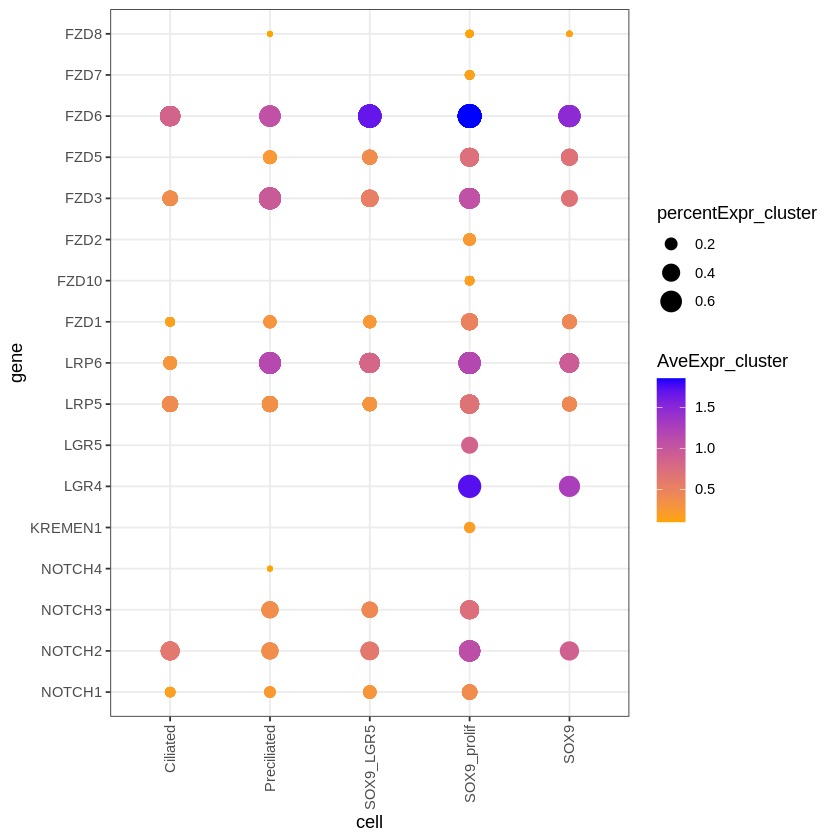

In [201]:
# filter genes
df = subset(cells2genes, gene %in% Receptors)
# ordre NOTCH4, NOTCH3, NOTCH2, NOTCH1, KREMEN1, LGR5, LGR4, LRP6, LRP5, FZD8, FZD7, FZD6, FZD5, FZD3, FZD2, FZD10, FZD1
df$gene = factor(df$gene, levels = c(grep('NOTCH', sort(unique(df$gene)), value = T) ,
                                     grep('KREMEN', sort(unique(df$gene)), value = T),
                                     grep('LGR', sort(unique(df$gene)), value = T),
                                     grep('LRP', sort(unique(df$gene)), value = T),
                                     grep('FZD', sort(unique(df$gene)), value = T)))
# filter cells
cells = intersect(c(lumenP, functionalP, basalP), epithelials)
df = df[ df$cell %in% cells ,]
# ordre epi_ciliated; epi_LGR5; epi_proliferative; Epi_CLU1;Epi_CLU2; 
df$cell = factor(df$cell, levels = cells)
ggplot(df,  aes(y = gene,
                    x = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster)) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) 
#     theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
ggsave(filename = 'invivo/cellphoneDB/out/dotplotReceptors_proliferative.pdf', dpi = 300, width = 6, height = 5)

## Proliferative: Ligands

 ligands: JAG2, JAG1, DLL1, NDP, SOSTDC1, WIF1, DKK1, RSPO3, RSPO1, WNT7A, WNT6, WNT5B, WNT5A, WNT4, WNT2B, WNT2, WNT11




### Load genes of interest

In [202]:
genes2plot = c(read.csv('../endometrium/data/cellphoneDB/genes2plot/dotplot2.txt', stringsAsFactors = F, sep = '\t', header = F)$V1,
               read.csv('../endometrium/data/cellphoneDB/genes2plot/dotplot4.txt', stringsAsFactors = F, sep = '\t', header = F)$V1)
genes2plot

[1] "WNT1"    "WNT2"    "WNT2B"   "WNT3"    "WNT3A"   "WNT4"    "WNT5A"  
 [8] "WNT5B"   "WNT6"    "WNT7A"   "WNT7B"   "WNT8A"   "WNT8B"   "WNT9A"  
[15] "WNT9B"   "WNT10A"  "WNT10B"  "WNT11"   "WNT16"   "DKK1"    "WIF1"   
[22] "SFRP"    "CER1"    "NDP"     "SOSTDC1" "RSPO1"   "RSPO2"   "RSPO3"  
[29] "RSPO4"   "DLL1"    "DLL3"    "DLL4"    "JAG1"    "JAG2"

### Generate cells2genes in cellphone for interactions containing genes of interest

In [203]:
cells2genes = get_cells2genes(CPresults, genes2filter = genes2plot)
head(cells2genes)
cells2genes$value = 1
cells2genes$cell = as.character(cells2genes$cell)
cells2genes$gene = as.character(cells2genes$gene)

,cell,gene,interaction,partner,id,AveExpr_cluster,percentExpr_cluster
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,SOX9_LGR5,SFRP4,SFRP4_WNT2B,SOX9_LGR5,SOX9_LGR5 SFRP4,0.4826087,0.2391304
2,SOX9_LGR5,NOTCH1,NOTCH1_JAG1,SOX9_LGR5,SOX9_LGR5 NOTCH1,0.2739131,0.2200000
3,SOX9_LGR5,CD46,CD46_JAG1,SOX9_LGR5,SOX9_LGR5 CD46,3.4608696,0.9156522
4,SOX9_LGR5,LRP5,LRP5_SOSTDC1,SOX9_LGR5,SOX9_LGR5 LRP5,0.2956522,0.2356522
5,SOX9_LGR5,LRP6,LRP6_SOSTDC1,SOX9_LGR5,SOX9_LGR5 LRP6,0.8165218,0.4982609
6,SOX9_LGR5,WNT7A,WNT7A_SFRP4,SOX9_LGR5,SOX9_LGR5 WNT7A,2.0782609,0.5313043


In [204]:
df = subset(cells2genes, gene %in% genes2plot)
unique(df$cell)

[1] "SOX9_LGR5"           "Preciliated"         "Ciliated"           
 [4] "Lumenal_1"           "Lumenal_2"           "SOX9_prolif"        
 [7] "Fibroblast_eS"       "PV_STEAP4"           "Endothelial_ACKR1"  
[10] "Endothelial_SEMA3G"  "Glandular"           "Glandular_secretory"
[13] "Fibroblast_dS"       "SOX9"                "Fibroblast_C7"

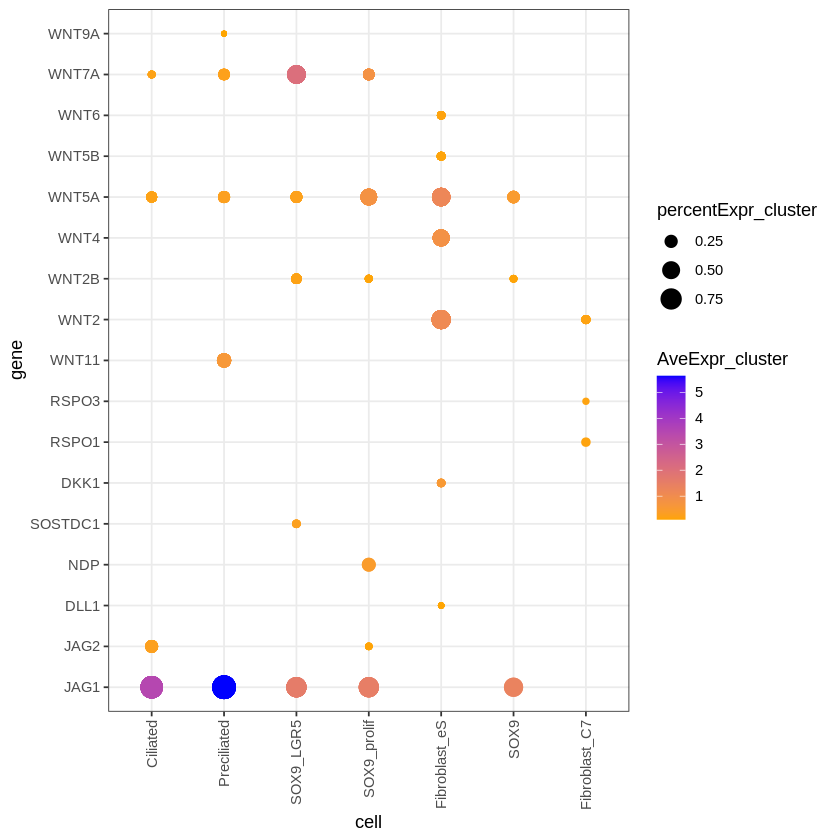

In [205]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
# ordre JAG2, JAG1, DLL1, NDP, SOSTDC1, WIF1, DKK1, RSPO3, RSPO1, WNT7A, WNT6, WNT5B, WNT5A, WNT4, WNT2B, WNT2, WNT11
df$gene = factor(df$gene, levels = c(grep('JAG', sort(unique(df$gene)), value = T),
                                     grep('DLL', sort(unique(df$gene)), value = T),
                                     'NDP', 'SOSTDC1','WIF1','DKK1',
                                     grep('RSP', sort(unique(df$gene)), value = T),
                                     grep('WNT', sort(unique(df$gene)), value = T)
                                    ))
# filter cells 
cells = c(lumenP, functionalP, basalP)
df = subset(df, cell %in% cells)
df$cell = factor(df$cell, levels = cells )
ggplot(df,  aes(y = gene,
                    x = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster)) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) 
#     theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
ggsave(filename = 'invivo/cellphoneDB/out/dotplotLigands_proliferative.pdf', dpi = 300, width = 6, height = 5)

## Secretory:  Receptors

receptors; NOTCH4, NOTCH3, NOTCH2, NOTCH1, KREMEN1, LGR5, LGR4, LRP6, LRP5, FZD8, FZD7, FZD6, FZD5, FZD3, FZD2, FZD10, FZD1




### Load genes of interest

### Generate cells2genes in cellphone for interactions containing genes of interest

In [207]:
cells2genes = get_cells2genes(CPresults, genes2filter = Receptors)
head(cells2genes)
cells2genes$value = 1
cells2genes$cell = as.character(cells2genes$cell)
cells2genes$gene = as.character(cells2genes$gene)

,cell,gene,interaction,partner,id,AveExpr_cluster,percentExpr_cluster
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,SOX9_LGR5,NOTCH1,NOTCH1_JAG1,SOX9_LGR5,SOX9_LGR5 NOTCH1,0.2739131,0.2200000
2,SOX9_LGR5,LRP5,LRP5_SOSTDC1,SOX9_LGR5,SOX9_LGR5 LRP5,0.2956522,0.2356522
3,SOX9_LGR5,LRP6,LRP6_SOSTDC1,SOX9_LGR5,SOX9_LGR5 LRP6,0.8165218,0.4982609
4,SOX9_LGR5,JAG1,JAG1_NOTCH2,SOX9_LGR5,SOX9_LGR5 JAG1,1.5878261,0.6530435
5,SOX9_LGR5,JAG1,JAG1_NOTCH3,SOX9_LGR5,SOX9_LGR5 JAG1,1.5878261,0.6530435
6,SOX9_LGR5,LRP5,FZD1_LRP5_WNT7A,SOX9_LGR5,SOX9_LGR5 LRP5,0.2956522,0.2356522


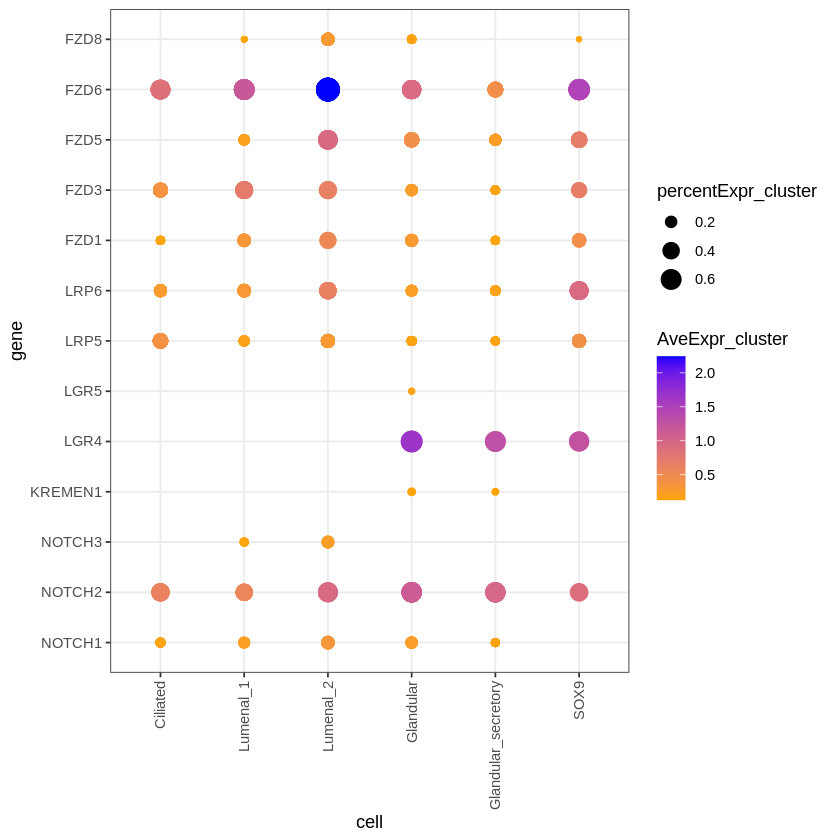

In [208]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
# ordre NOTCH4, NOTCH3, NOTCH2, NOTCH1, KREMEN1, LGR5, LGR4, LRP6, LRP5, FZD8, FZD7, FZD6, FZD5, FZD3, FZD2, FZD10, FZD1
df$gene = factor(df$gene, levels = c(grep('NOTCH', sort(unique(df$gene)), value = T) ,
                                     grep('KREMEN', sort(unique(df$gene)), value = T),
                                     grep('LGR', sort(unique(df$gene)), value = T),
                                     grep('LRP', sort(unique(df$gene)), value = T),
                                     grep('FZD', sort(unique(df$gene)), value = T)))
# filter cells
cells = intersect(c(lumenS, functionalS, basalS), epithelials)
df = df[ df$cell %in% cells ,]
# ordre epi_ciliated; epi_LGR5; epi_proliferative; Epi_CLU1;Epi_CLU2; 
df$cell = factor(df$cell, levels = cells)
ggplot(df,  aes(y = gene,
                    x = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster)) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) 
#     theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
ggsave(filename = 'invivo/cellphoneDB/out/dotplotReceptors_secretory.pdf', dpi = 300, width = 6, height = 5)

## Secretory: Ligands

 ligands: JAG2, JAG1, DLL1, NDP, SOSTDC1, WIF1, DKK1, RSPO3, RSPO1, WNT7A, WNT6, WNT5B, WNT5A, WNT4, WNT2B, WNT2, WNT11




### Load genes of interest

In [209]:
genes2plot = c(read.csv('../endometrium/data/cellphoneDB/genes2plot/dotplot2.txt', stringsAsFactors = F, sep = '\t', header = F)$V1,
               read.csv('../endometrium/data/cellphoneDB/genes2plot/dotplot4.txt', stringsAsFactors = F, sep = '\t', header = F)$V1)
genes2plot

[1] "WNT1"    "WNT2"    "WNT2B"   "WNT3"    "WNT3A"   "WNT4"    "WNT5A"  
 [8] "WNT5B"   "WNT6"    "WNT7A"   "WNT7B"   "WNT8A"   "WNT8B"   "WNT9A"  
[15] "WNT9B"   "WNT10A"  "WNT10B"  "WNT11"   "WNT16"   "DKK1"    "WIF1"   
[22] "SFRP"    "CER1"    "NDP"     "SOSTDC1" "RSPO1"   "RSPO2"   "RSPO3"  
[29] "RSPO4"   "DLL1"    "DLL3"    "DLL4"    "JAG1"    "JAG2"

### Generate cells2genes in cellphone for interactions containing genes of interest

In [210]:
cells2genes = get_cells2genes(CPresults, genes2filter = genes2plot)
head(cells2genes)
cells2genes$value = 1
cells2genes$cell = as.character(cells2genes$cell)
cells2genes$gene = as.character(cells2genes$gene)

,cell,gene,interaction,partner,id,AveExpr_cluster,percentExpr_cluster
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,SOX9_LGR5,SFRP4,SFRP4_WNT2B,SOX9_LGR5,SOX9_LGR5 SFRP4,0.4826087,0.2391304
2,SOX9_LGR5,NOTCH1,NOTCH1_JAG1,SOX9_LGR5,SOX9_LGR5 NOTCH1,0.2739131,0.2200000
3,SOX9_LGR5,CD46,CD46_JAG1,SOX9_LGR5,SOX9_LGR5 CD46,3.4608696,0.9156522
4,SOX9_LGR5,LRP5,LRP5_SOSTDC1,SOX9_LGR5,SOX9_LGR5 LRP5,0.2956522,0.2356522
5,SOX9_LGR5,LRP6,LRP6_SOSTDC1,SOX9_LGR5,SOX9_LGR5 LRP6,0.8165218,0.4982609
6,SOX9_LGR5,WNT7A,WNT7A_SFRP4,SOX9_LGR5,SOX9_LGR5 WNT7A,2.0782609,0.5313043


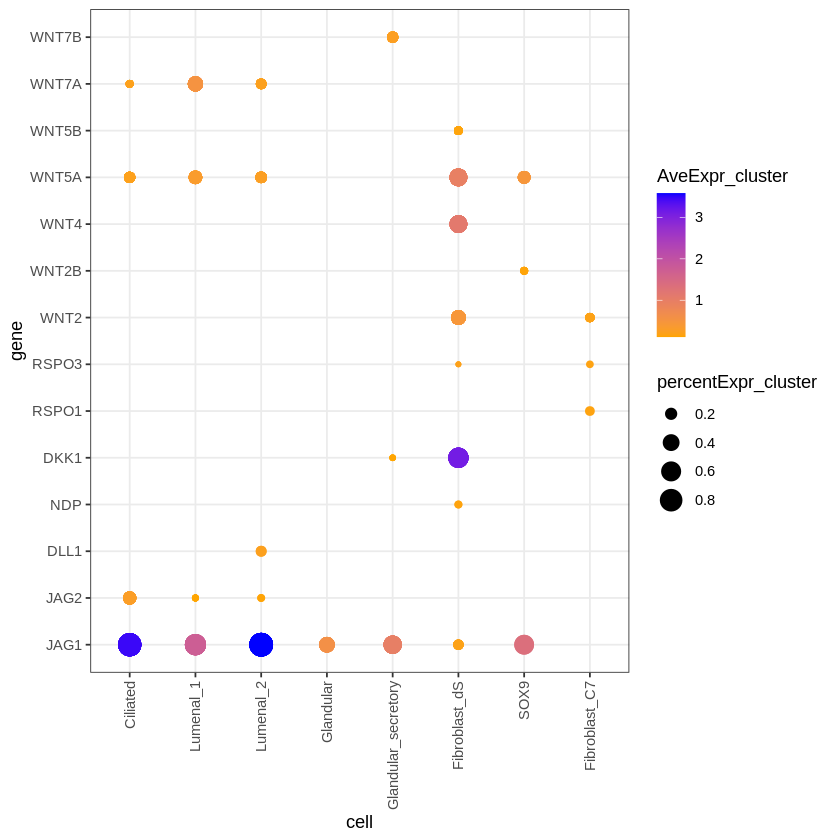

In [211]:
# filter genes
df = subset(cells2genes, gene %in% genes2plot)
# ordre JAG2, JAG1, DLL1, NDP, SOSTDC1, WIF1, DKK1, RSPO3, RSPO1, WNT7A, WNT6, WNT5B, WNT5A, WNT4, WNT2B, WNT2, WNT11
df$gene = factor(df$gene, levels = c(grep('JAG', sort(unique(df$gene)), value = T),
                                     grep('DLL', sort(unique(df$gene)), value = T),
                                     'NDP', 'SOSTDC1','WIF1','DKK1',
                                     grep('RSP', sort(unique(df$gene)), value = T),
                                     grep('WNT', sort(unique(df$gene)), value = T)
                                    ))
# filter cells 
cells = c(lumenS, functionalS, basalS)
df = subset(df, cell %in% cells)
# ordre Epi_CLU2 (antes WIF2); Epi_CLU1 (antes WIF1); Fibro_basal; stromal_dS; epi_glandular; epi_LGR5;  epi_ciliated
df$cell = factor(df$cell, levels = cells )
ggplot(df,  aes(y = gene,
                    x = cell,
                    color = AveExpr_cluster,
                    size = percentExpr_cluster)) +      
    geom_point() + 
    scale_color_gradient(low = 'orange', high = 'blue') +
    theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) 
#     theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
ggsave(filename = 'invivo/cellphoneDB/out/dotplotLigands_secretory.pdf', dpi = 300, width = 6, height = 5)

# Summary plot

General interactions bar plot: a) proliferative (colour 1); b) secretory (colour2). 
Y= numer of interactions; X= partners. 
X axis: eS; dS; fibro, end art, endo vein, PV_STEAP4, M, L, epi.ciliated,  epi.lumenal, epi.glandular, epi.basal


In [212]:
cells2genes = get_cells2genes(CPresults, genes2filter = unlist(Int2Gene[rownames(CPresults)]) )[, c('cell', 'interaction', 'partner') ] %>%
                unique(.)

In [213]:
cells_proliferative = c(lumenP, functionalP, basalP)
cells_secretory = c(lumenS, functionalS, basalS)

In [214]:
proliferative = subset(cells2genes, partner %in% cells_proliferative & cell %in% cells_proliferative)
# re-order so that epithelias are in cell
epi_idx = which(proliferative$partner %in% epithelials)
proliferative[epi_idx, c(1,3) ] = proliferative[epi_idx, c(3,1) ]
# duplicate when both cells are epithelials and reorder
epi_idx = which(proliferative$cell %in% epithelials &  proliferative$partner %in% epithelials)
proliferative = rbind(proliferative, proliferative[epi_idx, c(3, 2, 1)])
# Generate counts matrix and format as df for ggplot2
proliferative = unique(proliferative)
df = table(proliferative[, c(1,3)]) %>% 
    as.matrix(.) %>%
    melt(.)
dfT = table(proliferative[, c(1,3)]) %>% 
    as.matrix(.) %>%
    apply(., 1, sum) %>%
          t(.) %>%
    melt(.)
          
df$n_interactions = df$value
df$interactions_total = dfT$value
df$interactions_prop = df$n_interactions / df$interactions_total
df = subset(df, value > 0)
df$cell = factor(df$cell, levels = rev(cells_proliferative))
df$partner = factor(df$partner, levels = cells_proliferative)
head(df)

,cell,partner,value,n_interactions,interactions_total,interactions_prop
,<fct>,<fct>,<int>,<int>,<int>,<dbl>
1,Ciliated,Ciliated,47,47,256,0.1835938
4,Preciliated,Ciliated,72,72,270,0.2666667
6,SOX9_LGR5,Ciliated,137,137,441,0.3106576
9,Fibroblast_C7,Fibroblast_C7,36,36,36,1.0000000
12,SOX9,Fibroblast_C7,102,102,201,0.5074627
17,Fibroblast_eS,Fibroblast_eS,92,92,92,1.0000000


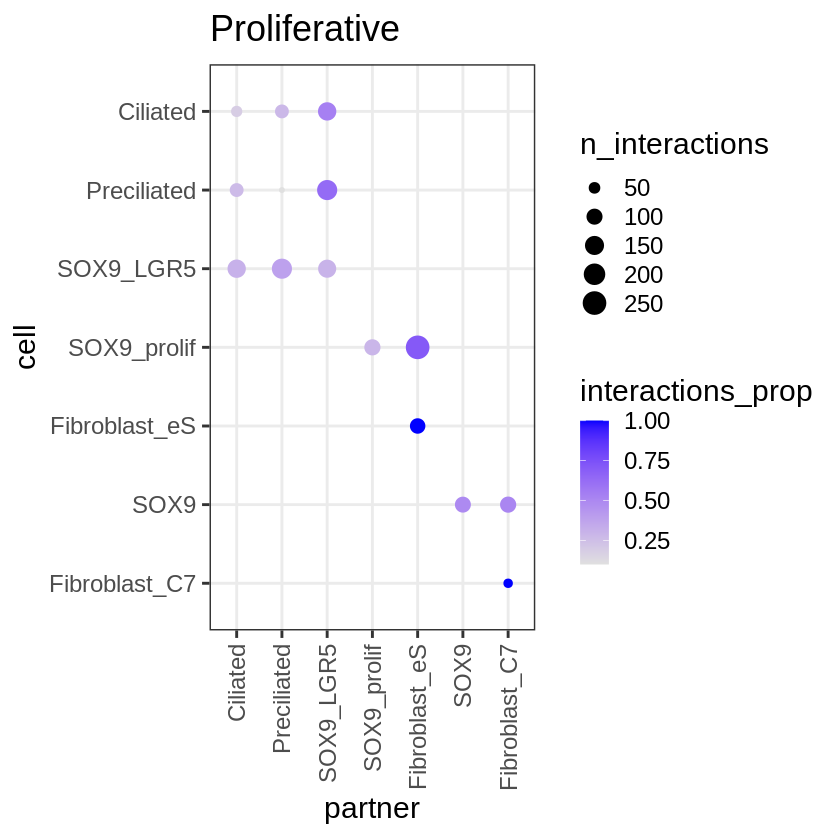

In [215]:
colors = c('#c466b0', '#71a2c7', '#60bddb',   '#70ccbe', 
               '#91bd80', '#bdb380',  '#d4db81',  '#dba781', '#e08b8b', 
               '#d96884', '#d9a5c3', '#cc8fdb')

ggplot(df,  aes(y = cell ,
                    x = partner,
                    color = interactions_prop,
                    size = n_interactions)) +      
    geom_point() + 
    scale_color_gradient(low = 'grey88', high = 'blue') +
    theme_bw(18) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    ggtitle('Proliferative')
ggsave(filename = 'invivo/cellphoneDB/out/dotplotSummary_Ninteractions_proliferative.pdf', dpi = 300, width = 7.4, height = 5.5)

In [216]:
secretory = subset(cells2genes, partner %in% cells_secretory & cell %in% cells_secretory)
# re-order so that epithelias are in cell
epi_idx = which(secretory$partner %in% epithelials)
secretory[epi_idx, c(1,3) ] = secretory[epi_idx, c(3,1) ]
# duplicate when both cells are epithelials and reorder
epi_idx = which(secretory$cell %in% epithelials &  secretory$partner %in% epithelials)
secretory = rbind(secretory, secretory[epi_idx, c(3, 2, 1)])
secretory = unique(secretory)
# Generate counts matrix and format as df for ggplot2
df = table(secretory[, c(1,3)]) %>% 
    as.matrix(.) %>%
    melt(.)
dfT = table(secretory[, c(1,3)]) %>% 
    as.matrix(.) %>%
    apply(., 1, sum) %>%
          t(.) %>%
    melt(.)
          
df$n_interactions = df$value
df$interactions_total = dfT$value
df$interactions_prop = df$n_interactions / df$interactions_total
df = subset(df, value > 0)
df$cell = factor(df$cell, levels = rev(cells_secretory))
df$partner = factor(df$partner, levels = cells_secretory)
head(df)

,cell,partner,value,n_interactions,interactions_total,interactions_prop
,<fct>,<fct>,<int>,<int>,<int>,<dbl>
1,Ciliated,Ciliated,47,47,221,0.2126697
6,Lumenal_1,Ciliated,86,86,248,0.3467742
7,Lumenal_2,Ciliated,88,88,238,0.3697479
10,Fibroblast_C7,Fibroblast_C7,36,36,36,1.0000000
16,SOX9,Fibroblast_C7,102,102,201,0.5074627
19,Fibroblast_dS,Fibroblast_dS,59,59,59,1.0000000


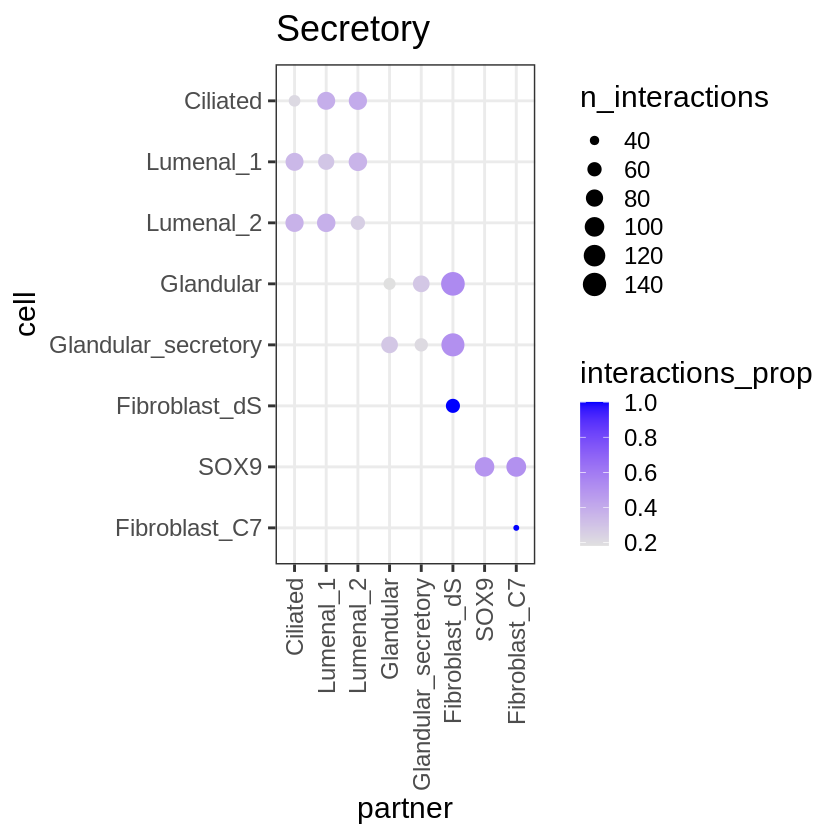

In [217]:
colors = c('#c466b0', '#71a2c7', '#60bddb',   '#70ccbe', 
               '#91bd80', '#bdb380',  '#d4db81',  '#dba781', '#e08b8b', 
               '#d96884', '#d9a5c3', '#cc8fdb')

ggplot(df,  aes(y = cell ,
                    x = partner,
                    color = interactions_prop,
                    size = n_interactions)) +      
    geom_point() + 
    scale_color_gradient(low = 'grey88', high = 'blue') +
    theme_bw(18) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    ggtitle('Secretory')
ggsave(filename = 'invivo/cellphoneDB/out/dotplotSummary_Ninteractions_secretory.pdf', dpi = 300, width = 8, height = 5.5)